In [7]:
%matplotlib inline

import poppy
poppy.conf.use_cupy = False

import matplotlib.pyplot as plt
plt.rcParams.update({
    'image.origin' : 'lower',
    'image.interpolation' : 'nearest',
    'figure.dpi' : 100,
})
from matplotlib.colors import LogNorm, SymLogNorm

import os

import numpy as np
from scoobpy import utils, iefc

from magpyx.utils import ImageStream
from magpyx.dm import control, dmutils
from magpyx import imutils, instrument

from purepyindi import INDIClient
from purepyindi import SwitchState as SwitchState0

from purepyindi2 import IndiClient, SwitchState #INDIClient
from time import sleep

from skimage.registration import phase_cross_correlation
from scipy.ndimage import center_of_mass

import deepdish as dd

In [1]:
import sys
sys.path.append('../')
from hcipy import *
import numpy as np
import kian_utils as kutils
# from utils import pad_or_crop

from matplotlib import pyplot as plt
from matplotlib import patches
from imshows import imshow1, imshow2, imshow3
import json
import scipy

from magaox.camera import XCam
from magaox.deformable_mirror import XDeformableMirror

import purepyindi2 as indi
import time
from magpyx.utils import ImageStream
from efc_utils import *


# Define DM mask (For rect Fourier probes function)
Nact = 34
dm_mask = np.ones((Nact,Nact), dtype=bool)
xx = (np.linspace(-Nact/2, Nact/2-1, Nact)+ 1/2)
x,y = np.meshgrid(xx,xx)
r = np.sqrt(x**2 + y**2)
dm_mask[r>Nact/2+1/2] = 0
print(dm_mask.sum())
imshow1(dm_mask)
plt.savefig('josh_dm_mask.png')


ModuleNotFoundError: No module named 'magaox'

In [8]:
from importlib import reload
reload(iefc)
reload(control)

<module 'magpyx.dm.control' from '/opt/MagAOX/source/magpyx/magpyx/dm/control.py'>

In [4]:
import os

os.getcwd()

'/data/users/xsup/EFC_KiloDM'

## Setup Camera

In [2]:
wavelength = 0.908
pixel_size = 13 #um
Fnumber = 69
psf_pixelscale_lamD = pixel_size / (Fnumber * wavelength)
print(psf_pixelscale_lamD)
Nact = 34
npsf = 256
cam = XCam('camsci1', pixel_size=pixel_size / (wavelength * Fnumber), use_hcipy=True)
grid = cam.grid

INFO:purepyindi2.transports:Connected to localhost:7624


0.2074953712571027


In [3]:
# From Kian Milani...
def create_fourier_modes(control_mask,
                         fourier_sampling=0.75, use='both', return_fs=False):
    xfp = (np.linspace(-npsf/2, npsf/2-1, npsf) + 1/2) * psf_pixelscale_lamD
    fpx, fpy = np.meshgrid(xfp,xfp)
    
    intp = scipy.interpolate.interp2d(xfp, xfp, control_mask) # setup the interpolation function
    
    xpp = np.linspace(-Nact/2, Nact/2-1, Nact) + 1/2
    ppx, ppy = np.meshgrid(xpp,xpp)
    
    fourier_lim = fourier_sampling * int(np.round(xfp.max()/fourier_sampling))
    xfourier = np.arange(-fourier_lim-fourier_sampling/2, fourier_lim+fourier_sampling, fourier_sampling)
    fourier_x, fourier_y = np.meshgrid(xfourier, xfourier) 
    
    # Select the x,y frequencies for the Fourier modes to calibrate the dark hole region
    fourier_grid_mask = ( (intp(xfourier, xfourier) * (((fourier_x!=0) + (fourier_y!=0)) > 0)) > 0 )
    
    fxs = fourier_x.ravel()[fourier_grid_mask.ravel()]
    fys = fourier_y.ravel()[fourier_grid_mask.ravel()]
    sampled_fs = np.vstack((fxs, fys)).T
    
    cos_modes = []
    sin_modes = []
    for f in sampled_fs:
        fx = f[0]/Nact
        fy = f[1]/Nact
        cos_modes.append( ( np.cos(2 * np.pi * (fx * ppx + fy * ppy)) * dm_mask ).flatten() ) 
        sin_modes.append( ( np.sin(2 * np.pi * (fx * ppx + fy * ppy)) * dm_mask ).flatten() )
    if use=='both' or use=='b':
        modes = cos_modes + sin_modes
    elif use=='cos' or use=='c':
        modes = cos_modes
    elif use=='sin' or use=='s':
        modes = sin_modes
    
    if return_fs:
        return np.array(modes), sampled_fs
    else:
        return np.array(modes)

def fourier_mode(lambdaD_yx, rms=1, acts_per_D_yx=(34,34), Nact=34, phase=0):
    idy, idx = np.indices((Nact, Nact)) - (34-1)/2.
    prefactor = rms * np.sqrt(2)
    arg = 2*np.pi*(lambdaD_yx[0]/acts_per_D_yx[0]*idy + lambdaD_yx[1]/acts_per_D_yx[1]*idx)
    return prefactor * np.cos(arg + phase)

def create_fourier_probes(control_mask,
                          fourier_sampling=0.25, 
                          shift=(0,0), 
                          nprobes=2, 
                          use_weighting=False,
                          plot=False, 
                          calc_responses=False): 
#     make probe modes from the sum of the cos and sin fourier modes
    fourier_modes, fs = create_fourier_modes(control_mask, fourier_sampling=fourier_sampling, use='both', return_fs=True)
    nfs = fourier_modes.shape[0]//2
    
    probes = np.zeros((nprobes, Nact, Nact))
    if use_weighting:
        fmax = np.max(np.sqrt(fs[:,0]**2 + fs[:,1]**2))
        sum_cos = 0.0
        sum_sin = 0.0
        for i in range(nfs):
            f = np.sqrt(fs[i][0]**2 + fs[i][1]**2)
            weight = f/fmax
            sum_cos += weight * fourier_modes[i]
            sum_sin += weight * fourier_modes[i+nfs]
        sum_cos = sum_cos.reshape(Nact,Nact)
        sum_sin = sum_sin.reshape(Nact,Nact)
    else:
        sum_cos = fourier_modes[:nfs].sum(axis=0).reshape(Nact,Nact)
        sum_sin = fourier_modes[nfs:].sum(axis=0).reshape(Nact,Nact)
    
    # nprobes=2 will give one probe that is purely the sum of cos and another that is the sum of sin
    cos_weights = np.linspace(1,0,nprobes)
    sin_weights = np.linspace(0,1,nprobes)
    
    if not isinstance(shift, list):
        shifts = [shift]*nprobes
    else:
        shifts = shift
    for i in range(nprobes):
        probe = cos_weights[i]*sum_cos + sin_weights[i]*sum_sin
        probe = scipy.ndimage.shift(probe, (shifts[i][1], shifts[i][0]))
        probes[i] = probe/np.max(probe)
        
        if plot: 
            response = np.abs(np.fft.ifftshift(np.fft.fft2(np.fft.fftshift( kutils.pad_or_crop(probes[i], 4*Nact) ))))
            imshow2(probes[i], response, pxscl2=1/4)

       
    return probes

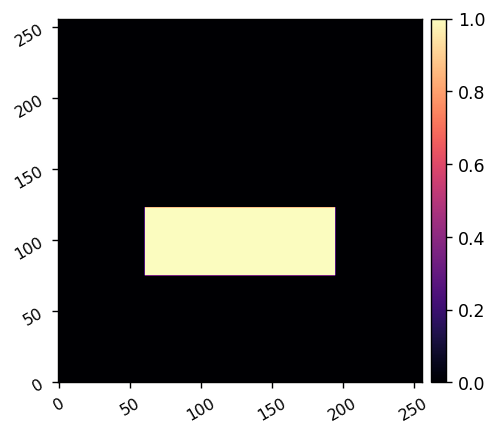

/tmp/ipykernel_110598/3303830336.py:7: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  intp = scipy.interpolate.interp2d(xfp, xfp, control_mask) # setup the interpolation function
/tmp/ipykernel_110598/3303830336.py:17: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatt

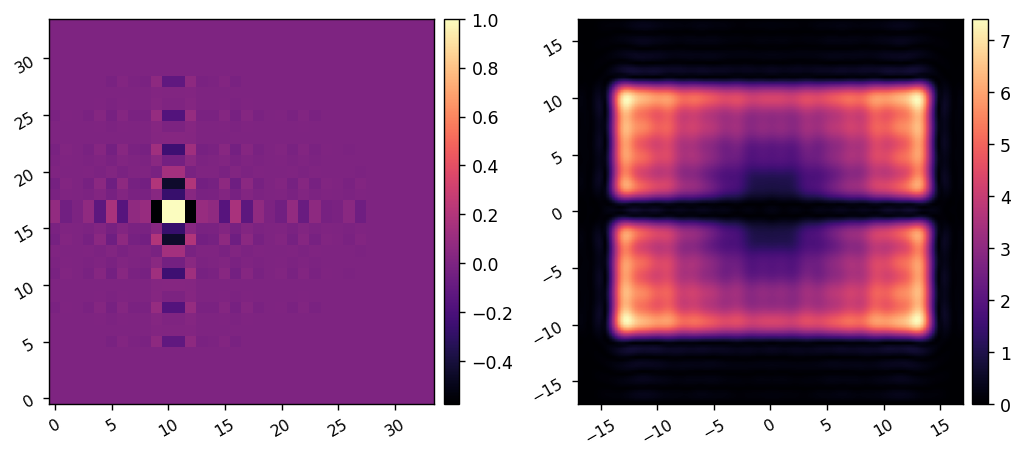

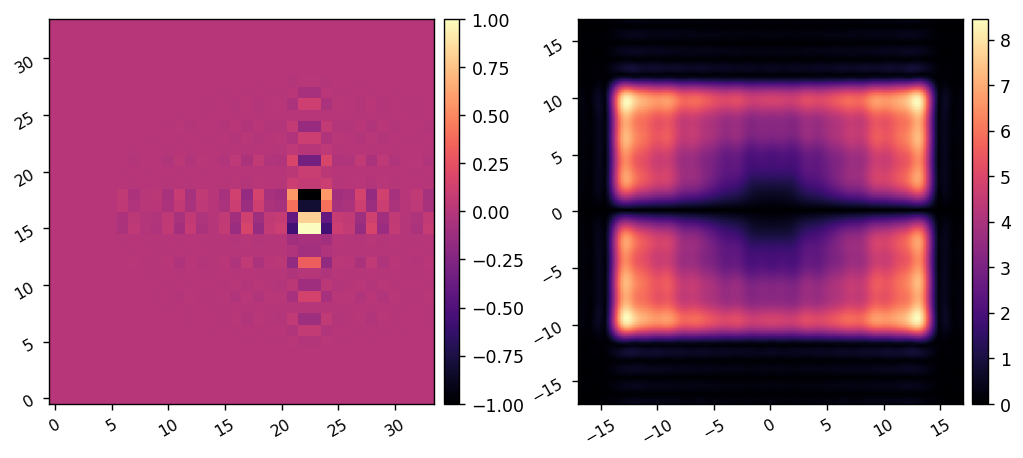

In [4]:
# Define pixel grid for control mask
x = (np.linspace(-npsf//2, npsf//2 -1, npsf,) + 1/2) * psf_pixelscale_lamD
x,y = np.meshgrid(x,x)

# Controllable fourier modes
iwa = 1
owa = 11
width = 28

control_mask = np.ones((npsf,npsf), dtype=bool)
control_mask *= (x<width//2)*(x>-width//2) * (y<-iwa) * (y>-owa)
# control_mask[x>-width//2]=1
imshow1(control_mask)

# Define Fourier probes (essentially sinc functions)
probe_modes = create_fourier_probes(control_mask, 
                                    shift=[(-6,0), (6,0)],
                                    use_weighting=True,
                                    plot=True)

## Setup Camera

In [5]:
wavelength = 0.908
pixel_size = 13 #um
Fnumber = 69
cam = XCam('camsci1', pixel_size=pixel_size / (wavelength * Fnumber), use_hcipy=True)
grid = cam.grid

INFO:purepyindi2.transports:Connected to localhost:7624


In [6]:
# instrument interface
client = indi.client.IndiClient()
client.connect()
time.sleep(0.5)

INFO:purepyindi2.transports:Connected to localhost:7624


## Tweeter connections

In [7]:
# Our probing interface

# Remove sqrt 2 to eliminate DM tilt
act_grid = make_pupil_grid(34, 34/30.0 * np.array([1.0, np.sqrt(2)]))
probe_dm = XDeformableMirror(dm='dmncpc', channel=8)

# Make the dark holes along the y-direction to align with the knife-edge
# probe_ind1 = np.ravel_multi_index((10, 17), (34,34))
# probe_ind2 = np.ravel_multi_index((11, 17), (34,34))
# indices = [probe_ind1, probe_ind2]

In [8]:
act_grid.shape

array([34, 34])

## Setup Camera

In [9]:
wavelength = 0.908
pixel_size = 13 #um
Fnumber = 69
cam = XCam('camsci1', pixel_size=pixel_size / (wavelength * Fnumber), use_hcipy=True)
grid = cam.grid

INFO:purepyindi2.transports:Connected to localhost:7624


In [10]:
 # Multiply y width of modes by sqrt 2 to account for projection
# probe_modes[0, :, :1] = probe_modes[0, :, :1]*np.sqrt(2)
# probe_modes[1, :, :1] = probe_modes[1, :, :1]*np.sqrt(2)

# probe_2 = act_grid.zeros()
# probe_2[probe_ind2] = 1.0

probe_1 = probe_modes[0]
probe_2 = probe_modes[1]

In [11]:
fourier_grid = make_pupil_grid([width, owa-iwa], [width, owa - iwa]).shifted([0, -(iwa+owa)/2])
fourier_modes = make_fourier_basis(act_grid, fourier_grid.scaled(2*np.pi), sort_by_energy=False)
nmodes = fourier_modes.num_modes

In [12]:
fourier_grid.shape

array([10, 28])

In [13]:
print(fourier_grid.shape)
print(10 * 240)
print(fourier_modes.num_modes)

[10 28]
2400
560


In [14]:
control_dm = XDeformableMirror(dm='dmncpc', channel=9)

In [15]:
print(nmodes)

560


In [16]:
# cal_loadpath = './Data/Calibrations/20240522/KnifeMask/'

# calib_load = 2
# calib_slopes = read_field(cal_loadpath + 'response_matrix_{:>02d}.fits'.format(calib_load))
# # calib_dark_hole_mask = read_field(cal_loadpath + 'dark_hole_mask_{:>02d}.fits'.format(calib_load))

# calib_dark_hole_mask = Field(control_mask.flatten(),cam.grid) # Use Kian's mask as starting point

# cos_power = np.sum(abs(calib_slopes) * calib_dark_hole_mask, axis=(1,2))[0::2]
# sin_power = np.sum(abs(calib_slopes) * calib_dark_hole_mask, axis=(1,2))[1::2]
# total_power = (cos_power + sin_power)

# analytical_cor_amplitudes = get_amplitude_correction_kilodm(fourier_grid)

# cor_amplitudes = Field(np.sqrt( (total_power / total_power.max())**-1 ) * analytical_cor_amplitudes, fourier_grid)

# imshow_field(cor_amplitudes, fourier_grid)
# plt.colorbar()
# plt.show()

In [17]:
# mode_mask = 

## Take calibration

In [18]:
probe_amp = 0.15

sleep = 0.02
num_cal_frames = 2
# num_cal_frames = 3 # Consider avging over more frames if cals are too noisy
num_skip = 2
cal_amp = 0.0075

differential_operator = np.array([[1,-1,0,0],[0,0,1,-1]]) / (2 * probe_amp)

ERROR:purepyindi2.transports:Connection failed. Reconnecting to localhost:7624 in 2 sec...
ERROR:purepyindi2.transports:Connection failed. Reconnecting to localhost:7624 in 2 sec...
ERROR:purepyindi2.transports:Connection failed. Reconnecting to localhost:7624 in 2 sec...
ERROR:purepyindi2.transports:Connection failed. Reconnecting to localhost:7624 in 2 sec...
ERROR:purepyindi2.transports:Failed to connect to localhost:7624 [[Errno 111] Connection refused]
INFO:purepyindi2.transports:Retrying in 2 sec...
ERROR:purepyindi2.transports:Failed to connect to localhost:7624 [[Errno 111] Connection refused]
INFO:purepyindi2.transports:Retrying in 2 sec...
ERROR:purepyindi2.transports:Failed to connect to localhost:7624 [[Errno 111] Connection refused]
INFO:purepyindi2.transports:Retrying in 2 sec...
ERROR:purepyindi2.transports:Failed to connect to localhost:7624 [[Errno 111] Connection refused]
INFO:purepyindi2.transports:Retrying in 2 sec...
ERROR:purepyindi2.transports:Failed to connect t

In [21]:
probe_dm.flatten()
probe_dm.send()
control_dm.flatten()
control_dm.send()

In [22]:
# probe_1[ :, :1] = probe_1[ :, :1]/np.sqrt(2)

In [23]:
# probe_1[ :, :1] = probe_1[ :, :1]*np.sqrt(2)

In [24]:
# probe_dm.actuators = probe_amp * probe_1.flatten()
# probe_dm.send()

In [25]:
# probe_1[

In [26]:
slopes = cam.grid.zeros((fourier_modes.num_modes, 2))
mean_image = 0

In [27]:
starting_mode = 0
nit = nmodes - starting_mode
slopes[starting_mode:(starting_mode+nit),:] = 0

start = time.time()
for mi in range(nit):
    mode_index = mi + starting_mode
    
    if mi % 10 == 0 and mi >0:
        current = time.time()
        elapsed = current - start
        print("Calibrating mode {:d} / {:d}.".format(mode_index, nmodes))
        print("seconds/mode {:f}".format(elapsed/10))
        start = current

    images = cam.grid.zeros((4,))
    for sfo in [-1.0, 1.0]:
        
        # control_dm.actuators += sfo * cor_amplitudes[mi//2] * cal_amp * fourier_modes[mode_index]
        control_dm.actuators += sfo * cal_amp * fourier_modes[mode_index]

        control_dm.send(0.01)
        
        images = take_measurement(probe_dm, cam, [probe_1.flatten(), probe_2.flatten()], probe_amp, 
                                  options={'sleep':sleep, 'num_im':num_cal_frames, 'num_skip':num_skip})      
        mean_image += np.mean(images, axis=0)
        
        processed_images = field_dot(differential_operator, images)
        # slopes[mode_index] += processed_images / (4 * sfo * cal_amp * cor_amplitudes[mi//2])
        slopes[mode_index] += processed_images / (4 * sfo * cal_amp)

        
        # control_dm.actuators -= sfo * cor_amplitudes[mi//2] * cal_amp * fourier_modes[mode_index]
        control_dm.actuators -= sfo * cal_amp * fourier_modes[mode_index]

        
control_dm.send(0.01)
#mean_image /= (2 * dh_dm.num_actuators)

Calibrating mode 10 / 560.
seconds/mode 3.312095


KeyboardInterrupt: 

## Make dark hole aperture

In [ ]:
reference_image = cam.grab_stack(120)

In [ ]:
mean_slope_image = np.mean(abs(slopes), axis=(0,1))
print(mean_image.shape)

dI = mean_slope_image - reference_image
dI /= dI.max()

In [ ]:
new_grid = cam.grid # make_pupil_grid([256, 128], [256/5, 128/5]).shifted([0, -64/5])
sr = 1
magnification = 1.0

dark_hole_iwa = iwa
dark_hole_owa = owa
dark_hole_heigth = abs(dark_hole_owa - dark_hole_iwa)
dark_hole_width = width

dh_center = [0, -(dark_hole_owa+dark_hole_iwa)/2]
dh_size = np.array([dark_hole_width, dark_hole_heigth]) + 1
# dark_hole_mask = Field(make_rectangular_aperture(dh_size, center=dh_center)(new_grid),new_grid)
dark_hole_mask = Field(control_mask.flatten(),new_grid)


plt.figure()
imshow_field(dark_hole_mask)

plt.figure()
plt.subplot(1,2,1)
#imshow_field(window_field(slopes[35,0] * dark_hole_mask, [0,0], 150, 150))
imshow_field(slopes[4,0], new_grid)
plt.subplot(1,2,2)
#imshow_field(window_field(slopes[35,1] * dark_hole_mask, [0,0], 150, 150))
imshow_field(slopes[14,1], new_grid)
plt.show()

In [ ]:
cos_power = np.sum(abs(slopes) * dark_hole_mask, axis=(1,2))[0::2]
sin_power = np.sum(abs(slopes) * dark_hole_mask, axis=(1,2))[1::2]
total_power = (cos_power + sin_power)
#total_power[180:] = np.nan

imshow_field(total_power , fourier_grid, vmax=5e8)
plt.colorbar()
plt.show()

In [ ]:
imshow_psf(dI, vmax=1.0, vmin=1e-3)

plt.figure()
imshow_psf(dI * dark_hole_mask , vmax=1.0, vmin=1e-3)
plt.show()

## Closed-loop EFC

In [ ]:
dh_response_matrix = slopes[:, :, dark_hole_mask>0].reshape((fourier_modes.num_modes, -1)).T
dh_control_matrix = inverse_tikhonov(dh_response_matrix, rcond=1e-4)
print(dh_response_matrix.shape)
print(control_dm.num_actuators)

In [ ]:
probe_dm.reset()
probe_dm.send(0.1)
control_dm.reset()
control_dm.send(0.1)

control_dm._offset_map = 0
cmd = 0

In [352]:
probe_dm.reset()
probe_dm.send(0.1)

In [353]:
num_cal_frames = 1
gain = 0.3
leakage = 0.01
sleep = 0.01
t_correction = 1


In [214]:
current_texp = cam.exposure_time
print(current_texp)

0.25


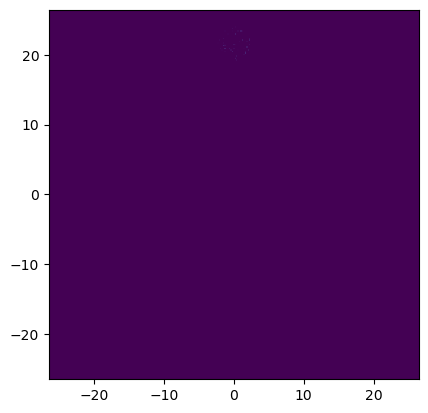

In [354]:
im = cam.grab_stack(10)
im -= np.median(im)
norm_phot_aperture = make_circular_aperture(5.0, [0., 21.5])(cam.grid)
imshow_field(im/im.max() * norm_phot_aperture, vmax=0.01, vmin=0)
plt.show()

In [355]:
lab_norm = np.sum(cam.grab_stack(100) * norm_phot_aperture)

In [356]:
norm_sky = 1
restart_norm = True

In [362]:
num_cal_frames = 2
for i in range(25):
    
    images = take_measurement(probe_dm, cam, [probe_1.flatten(), probe_2.flatten()], probe_amp, options={'sleep':sleep, 'num_im':num_cal_frames, 'num_skip':1})      
    
    norm_im = np.sum(np.mean(images, axis=0) * norm_phot_aperture)
    if restart_norm:
        norm_sky = norm_im
        restart_norm = False
    else:
        norm_sky = 0.95 * norm_sky + 0.05 * norm_im
    
    processed_images = field_dot(differential_operator, images * lab_norm / norm_sky)
    
    measurement = processed_images[:, dark_hole_mask>0].ravel()
    reconstruction = dh_control_matrix.dot(measurement)
    cmd = (1-leakage) * cmd - gain * reconstruction
    
    control_dm.actuators = fourier_modes.linear_combination(cmd)
    control_dm.send(sleep)

In [363]:
great_dark_hole_cmd = cmd.copy()

In [364]:
control_dm.actuators = fourier_modes.linear_combination(cmd)
control_dm.send(sleep)

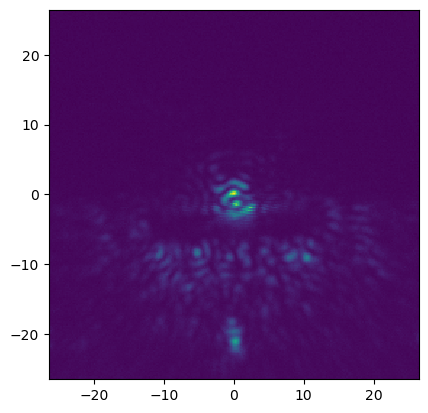

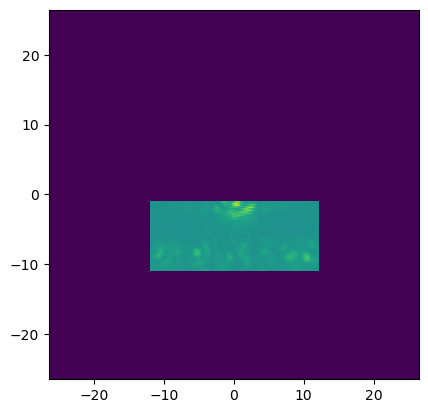

In [375]:
im = cam.grab_stack(30)

plt.figure()
# imshow_field(im, vmax=im.max()*0.01)
imshow_field(im)

plt.figure()
# imshow_field(dark_hole_mask * im, vmax=im.max()*0.01)
imshow_field(dark_hole_mask * im, vmax=im.max())



## Save calibration files

In [376]:
import json

In [377]:
lab_norm

Field(273977.98)

In [383]:
savepath = './Data/Calibrations/20240522/KnifeMask/'

calib = 2

write_field(slopes, savepath + 'response_matrix_{:>02d}.fits'.format(calib))
# write_field(dark_hole_mask, savepath + 'dark_hole_mask_{:>02d}.fits'.format(calib))
write_field(Field(fourier_modes._transformation_matrix.T, control_dm.grid), savepath + 'control_modes_{:>02d}.fits'.format(calib))
write_field(Field([probe_1.flatten(), probe_2.flatten()], probe_dm.grid), savepath + 'probe_modes_{:>02d}.fits'.format(calib))
write_field(norm_phot_aperture, savepath + 'normalization_aperture_{:>02d}.fits'.format(calib))
write_field(cor_amplitudes, savepath + 'correction_amplitudes_{:>02d}.fits'.format(calib))

In [232]:
# np.savetxt(savepath + 'great_dark_hole_pattern_cmd_{:>02d}.txt'.format(calib), great_dark_hole_cmd)


In [384]:
header = {
    'cal_amp' : cal_amp,
    'probe_amp' : probe_amp,
    'iwa' : iwa,
    'owa' : owa,
    'width' : width,
    'lab_norm' : lab_norm.item(),
    'cam' : {
        'width' : 256,
        'height' : 256,
        'x' : 479,
        'y' : 508
    }
}

print(header)

with open(savepath + 'header_information_{:>02}.json'.format(calib), 'w') as af:
    json.dump(header, af)

{'cal_amp': 0.0075, 'probe_amp': 0.15, 'iwa': 1, 'owa': 11, 'width': 24, 'lab_norm': 273977.98, 'cam': {'width': 256, 'height': 256, 'x': 479, 'y': 508}}
